<a href="https://colab.research.google.com/github/gcunhase/ML-Notebook/blob/master/models/rnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

## 1. Libraries
*Installing and importing necessary packages*

*Working with **Python 3.6** and **PyTorch 1.0.1** *

In [11]:
!nvidia-smi

Thu Apr  4 12:34:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   2430MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
import sys
import os
# !{sys.executable} -m pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
# !{sys.executable} -m pip install torch torchvision matplotlib
!{sys.executable} -m pip install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!{sys.executable} -m pip install torchvision matplotlib

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer

print("PyTorch version: {}".format(torch.__version__))
cudnn_enabled = torch.backends.cudnn.enabled
print("CuDNN enabled" if cudnn_enabled else "CuDNN disabled")

PyTorch version: 1.0.1.post2
CuDNN enabled


## 2. Variables
*Indicate the root directory where the data must be downloaded, the directory where the results should be saved and the type of RNN (conventional, LSTM, GRU) and its respective hyper-parameters*

In [75]:
# Make reproducible run
torch.manual_seed(1)

# Settable parameters
params = {'root': './data/',
          'results_dir': './results/',
          'hidden_size': 128,
          'input_size': 28,  # MNIST data input (img shape: 28*28)
          'sequence_length': 28,
          'lr': 1e-3,
          'weight_decay': 1e-10, # 5e-4,  # 1e-10,
          'momentum': 0.9,
          'num_classes': 10,  # class 0-9
          'batch_size': 128,
          'model_type': 'RNN',  # Options = [RNN, LSTM, GRU]
          'num_layers': 1,
          'epochs': 10,
          'save_step': 200,
          'use_cuda': True,
         }

# GPU usage
print("GPU: {}, number: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
device = torch.device('cuda') if params['use_cuda'] and torch.cuda.is_available() else torch.device('cpu')

# Ensure results directory exists
if not os.path.exists(params['results_dir']):
    os.mkdir(params['results_dir'])

GPU: True, number: 1


## 3. Dataset

*Normalizing between (0.1307, 0.3081): global mean and standard deviation of the MNIST dataset*

In [76]:
# Get train and test datasets
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# trans = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(
    root=params['root'],  # directory where the data is or where it will be saved
    train=True,  # train dataset
    download=True,  # download if you don't have it
    transform=trans)  # converts PIL.image or np.ndarray to torch.FloatTensor of shape (C, H, W) and normalizes from (0.0, 1.0)
mnist_test = datasets.MNIST(root=params['root'], train=False, download=True, transform=trans)  # transforms.ToTensor()
print("MNIST Train {}, Test {}".format(len(mnist_train), len(mnist_test)))

# Dataloader: mini-batch during training
mnist_train_dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=params['batch_size'], shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=params['batch_size'], shuffle=True)

MNIST Train 60000, Test 10000


*Dataset examples*

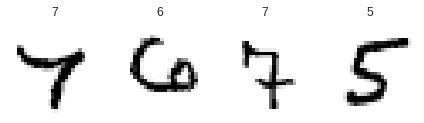

In [72]:
# Plot examples
examples = enumerate(mnist_test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(nrows=1, ncols=4)
for i, ax in enumerate(axes.flat):
  ax.imshow(example_data[i][0]) 
  ax.set_title('{}'.format(example_targets[i]))
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()

## 4. The Model: RNN
$h_t = \sigma(W x_t + U h_{t-1})$

Some important information is: 
* Input size: number of expected features in input $x$
* Hidden size: number of features in hidden state $h$
* After forward propagation, output has shape (batch_size, seq_length, hidden_size)
* If you want to initialize of RNN with hidden and cell states different than zero, modify variables $h0$ and $c0$. Otherwise, you may set them as *None*.

In [0]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.input_size = params['input_size']
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.model_type = params['model_type']
        
        if self.model_type == 'RNN':
            self.rnn = nn.RNN(self.input_size, self.hidden_size, num_layers=self.num_layers, bias=True, nonlinearity='tanh', dropout=0.2)
        elif self.model_type == 'GRU':
            self.rnn = nn.GRU(self.input_size, self.hidden_size, num_layers=self.num_layers, bias=True, dropout=0.2)
        else:  # 'LSTM'
            self.rnn = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, dropout=0.2)

        self.bn = nn.BatchNorm1d(self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, params['num_classes'])
        self.softmax = nn.ReLU()  # nn.LogSoftmax()  # Softmax()
        
    def forward(self, x):           
        # Set initial hidden state $h0$ and cell state $c0$
        h0 = torch.zeros(self.num_layers, self.input_size, self.hidden_size, dtype=torch.float32)
        c0 = torch.zeros(self.num_layers, self.input_size, self.hidden_size, dtype=torch.float32)

        # Forward propagate RNN
        if self.model_type == 'LSTM':
            out, hidden = self.rnn(x, None)  # (h0, c0)) 
        else:
            out, hidden = self.rnn(x, None)  # h0)
        
        # Decode last hidden state
        out_fc = self.bn(out[:, -1, :])
        out_fc = self.fc(out_fc)
        out_fc = self.softmax(out_fc)
        # print("Input {} -> Output shape {} -> {} | Last shape {}".format(x.shape, out.shape, out_fc.shape, out[:, -1, :].shape))
        return out_fc

*Instantiate model and optimizer*

In [82]:
# Instantiate model
model = RNN()
# Allow for parallelism if multiple GPUs are detected
model = nn.DataParallel(model)
# Transfer model to device (CPU or GPU according to your preference and what's available)
model = model.to(device)

# Loss criterion and optimizer
criterion = nn.CrossEntropyLoss()  # L1Loss, SmoothL1Loss, NLLLoss(), CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
# optimizer = torch.optim.ASGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
# optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# New results dir based on model's parameters
res_dir = params['results_dir'] + '{}_{}layers_sgd_lr{}_weight{}_trainSize_{}_testSize_{}/'.\
    format(params['model_type'], params['num_layers'], params['lr'],
           params['weight_decay'], len(mnist_train), len(mnist_test))

if not os.path.exists(res_dir):
    os.mkdir(res_dir)

print("res_dir: {}".format(res_dir))
log_file = open(res_dir + 'log.txt', 'w')

res_dir: ./results/RNN_1layers_sgd_lr0.001_weight1e-10_trainSize_60000_testSize_10000/


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## 5. Train

Completed 0.02%: Epoch/step [1/10 - 1/469], loss 2.2998, acc 7.81, best acc 7.81
Completed 4.29%: Epoch/step [1/10 - 201/469], loss 2.3046, acc 14.06, best acc 14.06
Completed 8.55%: Epoch/step [1/10 - 401/469], loss 2.3139, acc 11.72, best acc 14.06
Completed 10.02%: Epoch/step [2/10 - 1/469], loss 2.3030, acc 10.94, best acc 14.06
Completed 14.29%: Epoch/step [2/10 - 201/469], loss 2.3049, acc 10.16, best acc 14.06
Completed 18.55%: Epoch/step [2/10 - 401/469], loss 2.3112, acc 10.16, best acc 14.06
Completed 20.02%: Epoch/step [3/10 - 1/469], loss 2.2959, acc 7.03, best acc 14.06
Completed 24.29%: Epoch/step [3/10 - 201/469], loss 2.2863, acc 10.16, best acc 14.06
Completed 28.55%: Epoch/step [3/10 - 401/469], loss 2.3048, acc 12.50, best acc 14.06
Completed 30.02%: Epoch/step [4/10 - 1/469], loss 2.3008, acc 10.16, best acc 14.06
Completed 34.29%: Epoch/step [4/10 - 201/469], loss 2.3014, acc 14.84, best acc 14.84
Completed 38.55%: Epoch/step [4/10 - 401/469], loss 2.3087, acc 9.38

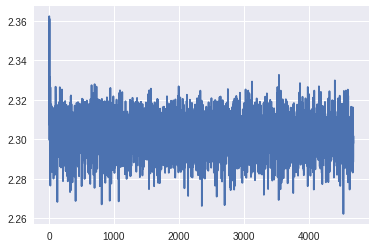

Model took 3.4720 mins (0.0579 hrs) to finish training with best train accuracy of 14.8438%


In [83]:
start_timer = timer()

loss_arr = []
train_acc_arr = []
first_time = True
total_num_steps = len(mnist_train_dataloader)
# model.train()

model.zero_grad()
for e in range(1, params['epochs']+1):
    for i, (img, label) in enumerate(mnist_train_dataloader):
        # img = img.reshape(-1, params['sequence_length'], params['input_size']).to(device)
        # img = img.view(-1, params['sequence_length'], params['input_size']).to(device)
        img = Variable(torch.squeeze(img)).to(device)
        # img = torch.transpose(img, 1, 2)
        label = Variable(label).to(device)
        
        #img_cpu = img.cpu()
        #print(np.shape(img_cpu))
        #print(np.shape(img_cpu[1,:,:]))
        #plt.imshow(img_cpu[1,:,:])
        #plt.tight_layout()
        #plt.show()
        
        # Forward
        out = model(img)
        loss = criterion(out, label)
        
        # Backward
        optimizer.zero_grad()
        #for param in model.parameters():
        #  print(param.grad.data.sum())

        # start debugger
        # import pdb; pdb.set_trace()

        loss.backward()
        
        optimizer.step()
        scheduler.step(loss)

        loss_arr.append(loss.item())
        
        if i % params['save_step'] == 0:
            # Train Accuracy
            _, predicted = torch.max(out.data, 1)
            total = label.size(0)
            correct = (predicted == label).sum().item()
            acc = 100 * correct / total
            train_acc_arr.append(acc)
            # Print update
            perc = 100 * ((e-1)*total_num_steps + (i+1))/float(params['epochs'] * total_num_steps)
            str_res = "Completed {:.2f}%: Epoch/step [{}/{} - {}/{}], loss {:.4f}, acc {:.2f}, best acc {:.2f}".format(perc, e, params['epochs'], i+1, total_num_steps, loss.item(), acc, max(train_acc_arr))
            print(str_res)  # print("\r" + str_res, end="")
        #    # Save log
        #    log_file.write(str_res)
            
# Save training loss
plt.plot(loss_arr)
# plt.semilogy(range(len(loss_arr)), loss_arr)
plt.savefig(res_dir + 'loss.png')
# Save model checkpoint
torch.save(model.state_dict(), res_dir + 'model.ckpt')
plt.show()
log_file.close()

end_timer = timer() - start_timer
print("Model took {:.4f} mins ({:.4f} hrs) to finish training with best train accuracy of {:.4f}%".format(end_timer/60, end_timer/3600, max(train_acc_arr)))

## 6. Test

Test Accuracy: 11.2200 %
Shapes: img torch.Size([16, 28, 28]), label torch.Size([16]), predicted torch.Size([16])
Label: tensor([7, 7, 6, 3, 3, 4, 3, 5, 7, 0, 1, 2, 0, 9, 7, 9], device='cuda:0')
Predicted: tensor([0, 0, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


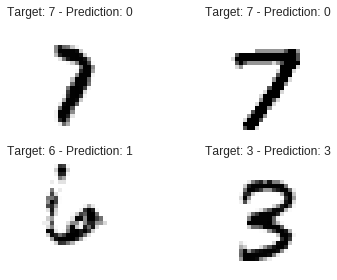

In [84]:
# Testing doesn't require the use of gradients since weights aren't being updated
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for img, label in mnist_test_dataloader:
        img = torch.squeeze(img).to(device)
        label = label.to(device)
        
        # Forward
        out = model(img)
        
        # Test
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    # Accuracy
    print('Test Accuracy: {:.4f} %'.format(100 * correct / total)) 

    # Show 4 test images
    fig, axes = plt.subplots(nrows=2, ncols=2)
    img_cpu = img.cpu()
    label_cpu = label.cpu()
    print("Shapes: img {}, label {}, predicted {}".format(img_cpu.size(), label_cpu.size(), predicted.size()))
    print("Label: {}".format(label))
    print("Predicted: {}".format(predicted))
    for i, ax in enumerate(axes.flat):
      ax.imshow(img_cpu[i]) 
      ax.set_title('Target: {} - Prediction: {}'.format(label_cpu[i], predicted[i]))
      ax.set_xticks([])
      ax.set_yticks([])
    plt.tight_layout()

## 7. Summary
*Steps per epoch on 128 batch_size = 469, using GPU*

<table align="left">
  <tr>
    <td><b>Model</b></td><td><b>Epoch</b></td><td align="center"><b>Train Acc (%)</b></td><td align="center"><b>Test Acc (%)</b></td><td align="center"><b>Training Time (min)</b></td>
  </tr>
  <tr>
    <td rowspan="2">RNN</td><td>10</td><td align="center">17</td><td align="center">12</td><td align="center">3.6</td>
  </tr>
  <tr>
    <td>30</td><td align="center">18</td><td align="center">11</td><td align="center">11.6</td>
  </tr>
  <tr>
    <td rowspan="2">LSTM</td><td>10</td><td align="center">20</td><td align="center">12</td><td align="center">3.35</td>
  </tr>
  <tr>
    <td>30</td><td align="center">20</td><td align="center">12</td><td align="center">11.6</td>
  </tr>
  <tr>
    <td rowspan="2">GRU</td><td>10</td><td align="center">15</td><td align="center">12</td><td align="center">3.6</td>
  </tr>
  <tr>
    <td>30</td><td align="center">20</td><td align="center">12</td><td align="center">12</td>
  </tr>
</table>